# For those who acquire COVID-19 and recover, how long does the illness last ? 
## (Time to event analysis of COVID-19 recovery data from India.)  
 **   Disclaimer : This is an unofficial analysis of sparsely populated data, by a data science enthusiast.
    I am not a health care professional and the answers obtained here should not be considered official much less definitive.
    The objective is to glean what insights we can from the data exposed to us, and generate discussion on ways to tackle such questions.** 
    
    
   **   (Uses Patient level COVID-19 data from India,  
         Source of Data: https://api.covid19india.org/csv/)**


<a id='table_contents'></a>
## Table of Contents
#### <a href= '#questions'> 1. Questions we want to answer</a>
#### <a href='#about_data'> 2. About the Data</a>
#### <a href ='#recovery_focus'> 3. Why focus on recovery?</a> 
#### <a href ='#recovery_overall'> 4. Overall recovery time</a>
#### <a href = '#recovery_sex'> 5. Recovery rates by Sex</a>
#### <a href = '#recovery_age'> 6. Recovery rates by Age Buckets</a>
#### <a href = '#recovery_age_sex'> 7. Recovery rates by Age and sex </a>
#### <a href = '#what_learned'> 8. What did we learn?</a>
#### <a href = '#references'> 9. References </a>


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
import pprint
from IPython.display import HTML
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore')
!pip -q install lifelines
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
;

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


''

<a id ='questions'></a>

## 1. Questions we want to answer:

The main questions we wish to delve into are as follows:

* Given that a person falls ill with COVID-19 and then makes a recovery, how long does the illness last?
* What factors do the time to recovery depend on? The analysis considers Sex and Age as factors that could potentially impact recovery times. 




<a id='about_data'></a>
<a href ='#table_contents'> Return to Table of Contents </a>
## 2. About the Data

Patient level COVID-19 data from India was sourced from https://api.covid19india.org/csv/. By their own description the website is a volunteer-driven, crowdsourced database for COVID-19 stats and patient tracing in India. The source for each patient's information is given as links to newspaper and magazine articles. 

The data has a column each, for the date the case was announced (**Date Announced**), the current status of the case (**Current Status** among: deceased, hospitalized, recovered) and the date the status changed to the current status (**Status Change Date**). 

The difference between the **Status Change Date** and the **Date Announced** was used as the time to recovery in this model. Though the **Date Announced** wouldn't be the date the patient got ill, it would be quite close to the date serious symptoms were reported. 

Data collection could not be perfect in such a crowd sourced venture during a pandemic. Often the **Status Change Date**, was the same as the **Date Announced**. This is probably due to lack of information about when the case status changed. Attributes like gender and age are quite sparsely populated. The number of recoveries recorded were just 181 out of 17,306 observations. In most cases the current status was listed as hospitalized, probably as the recovery of the case wasn't tracked. I did not include the hospitalized cases as censored observations in my analysis as is often done in *Time To Event* modelling because they were the overwhelming majority and their timelines weren't tracked. Hence including them would reduce the insights we could glean from the few cases where timelines and other attributes like gender and age were properly logged. 

The website itself states that due to the inability to track the changes in each case, they are deprecating the **Current Status** field. However, the data used in this analysis was of earlier cases (Those announced before April 19th 2020) and hence this information is sometimes available and can be used. 

Despite the shortcomings, we do get enough data to get information that answers some of our questions and points us in the direction of further research. We also develop a methodology for analysis that can be done if better anonymized data is available from hospitals.

For further questions about the data and my methodology please email me at gowri.thampi@gmail.com 





<a id ='recovery_focus'></a>
<a href ='#table_contents'> Return to Table of Contents </a>
## 3. Why focus on recovery? 

* Several models exist which try to predict the fatality rate and the factors affecting it. 
* Being ill for a long period of time has negative consequences too, eg: losses in productivity (I only know too well as a survivor of severe **R**epetitive **S**tress **I**njury)


In [2]:
#read the table from my kaggle input
covid = pd.read_table('raw_data.csv', sep = ','  , usecols = list(range(0,20)))

#clean up some errors found in < .1% of this column, due to data import issues
covid = covid.loc[~covid['Status Change Date'].isin(['Imported', 'Local'])]
covid['Date Announced'] = pd.to_datetime(covid['Date Announced'],infer_datetime_format=True, errors = 'ignore',dayfirst = True)
covid['Status Change Date'] = pd.to_datetime(covid['Status Change Date'],infer_datetime_format=True, errors = 'ignore',dayfirst = True)


#check data types
#print(covid.dtypes)

In [3]:
#Filter out those who recovered from Covid19 - most cases are still hospitalized

covid_recovered = covid[covid['Current Status']== 'Recovered']

#calculate time to recovery in days
covid_recovered['time_to_recovery'] = (covid_recovered['Status Change Date'] - covid_recovered['Date Announced']).dt.days
covid_recovered = covid_recovered[covid_recovered['time_to_recovery']!=0]
#check the data

#pd.set_option('display.max_rows', None)
#print(covid_recovered.shape)
#print(covid_recovered['time_to_recovery'].value_counts())
#print(covid.head)

<a id ='recovery_overall'></a>
<a href ='#table_contents'> Return to Table of Contents </a>
## 4. Overall recovery time

[*Boxplots*](https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/box-plot-review) show the median (line through the box), minimum, maximum( lower and upper whiskers) and the first and third quartile (within the rectangle) of a value. Value plotted here is the time to recovery, of the 181 patients who recovered and we have **Time to Recovery** information about. 






Median time to recovery is 14 days


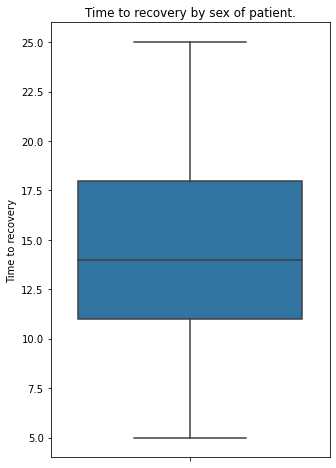

In [4]:
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
import seaborn as sns
%matplotlib inline
figsize = (5,8)
fig = plt.figure(figsize = figsize)
ax = sns.boxplot(y = 'time_to_recovery' , data = covid_recovered)
ax.set( ylabel = 'Time to recovery', title = 'Time to recovery by sex of patient.')

med_time_to_recovery =  covid_recovered['time_to_recovery'].median()
print("Median time to recovery is{0: .0f} days".format(med_time_to_recovery))

plt.show()

### What percentage of patients remain sick, a given number of days after diagnosis?

To visualize this, we draw what are known as [*Kaplan-Meier*](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) curves. In these curves, derived from our data, the Y axis shows what percentage of the total population who finally recovered, are still sick, and the X axis shows the number of days after diagnosis. For example, 10 days after diagnosis, roughly 60% of the people who finally recovered are still sick.
The steeper the slope of this curve, the faster the recovery time. Since everyone in our population finally recovered, we see that by the longest recovery time we have in our data (25 days) nobody is still sick. 


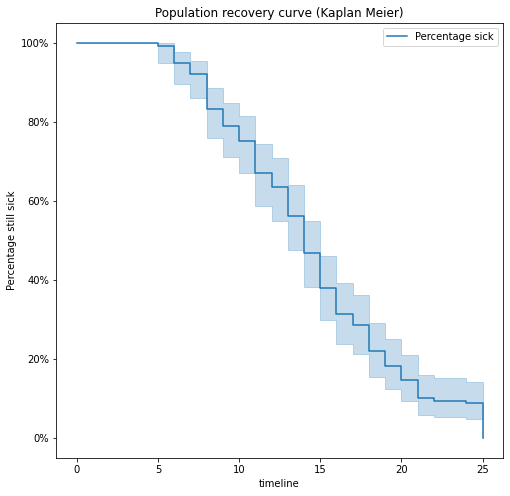

In [5]:


from lifelines import KaplanMeierFitter
figsize = (8,8)

kmf_data = covid_recovered['time_to_recovery'].value_counts()
time_to_recovery = covid_recovered['time_to_recovery']
event_occured = np.empty(len(time_to_recovery))
event_occured.fill(1)
#print(kmf_data)

## create a kmf object
kmf = KaplanMeierFitter() 
fig = plt.figure(figsize = figsize)
ax = fig.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set(xlabel = 'Days since diagnosis ' , ylabel = 'Percentage still sick', title = 'Population recovery curve (Kaplan Meier)')
kmf.fit(time_to_recovery, event_occured, label = 'Percentage sick')
kmf.plot(ax = ax)


<a id ='recovery_sex'></a>
<a href ='#table_contents'> Return to Table of Contents </a>
## 5. Recovery rates by Sex

For this part of the analysis we further filter out the data, leaving only those who also have the sex column filled out. We have 92 patients, 64 male and 28 female. The median time to recovery is greater for females(16 days) than males(14 days), that does run contrary to the fact that women have lower fatality rates from COVID-19 than men. The dataset is small, and the sexes are not equally represented in it, also there may be confounding due to a second variable (like age) disproportionately distributed in the two sexes, but to me this indicates a need for further research. 

A [*t-test*](https://en.wikipedia.org/wiki/Student%27s_t-test) run on the mean recovery times for the two sexes resulted in a p-value of 0.11, this indicates that we only have an eighty nine percent confidence that the mean recovery times for the two groups are different, not high enough to be conclusive at all, but it does merit investigation with a larger dataset when available. 

------  --
Male    64
Female  28
------  --
Median time to recovery for males is 14 days.
Median time to recovery for females is 16 days.


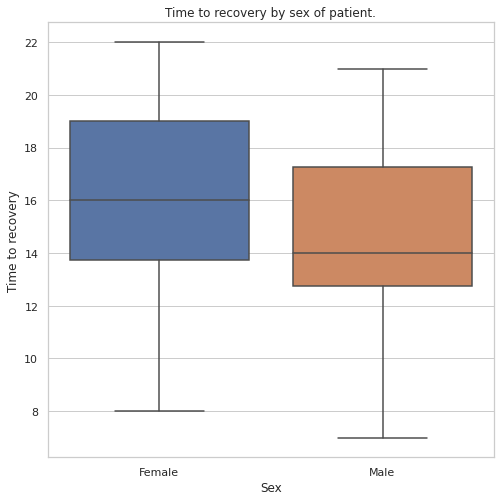

p-value  0.11


In [6]:


import matplotlib.pyplot as plt
from tabulate import tabulate
sns.set(style="whitegrid")


covid_gender = covid_recovered[pd.notnull(covid_recovered['Gender'])]
covid_gender.loc[covid_gender['Gender']=='F','Gender'] = 'Female'
covid_gender.loc[covid_gender['Gender']=='M','Gender'] = 'Male'
#print(covid_recovered.shape)
#print(covid_gender.shape)
#print(covid_gender[covid_gender['time_to_recovery']!=0].shape)

print(tabulate(pd.DataFrame(covid_gender['Gender'].value_counts())))

med_time_to_recovery_male =  covid_gender.loc[covid_gender['Gender']=='Male','time_to_recovery'].median()
print("Median time to recovery for males is{0: .0f} days.".format(med_time_to_recovery_male))

med_time_to_recovery_female =  covid_gender.loc[covid_gender['Gender']=='Female','time_to_recovery'].median()
print("Median time to recovery for females is{0: .0f} days.".format(med_time_to_recovery_female))

fig = plt.figure(figsize = figsize)
ax = sns.boxplot(x = 'Gender' , y = 'time_to_recovery' , data = covid_gender[covid_gender['time_to_recovery']!=0])
ax.set(xlabel = 'Sex' , ylabel = 'Time to recovery', title = 'Time to recovery by sex of patient.')
plt.close(2)
plt.close(3)
#plt.table(loc = 'bottom', cellText = cell_text)
plt.show()
ttest,pval = ttest_ind(covid_gender.loc[covid_gender['Gender']=='Female','time_to_recovery'],covid_gender.loc[covid_gender['Gender']=='Male','time_to_recovery'])
print("p-value {0: .2f}".format(pval))


**How many people remain sick a given number of days after diagnosis ?**

We again draw Kaplan-Meier curves for each sex, superimposed on the same axes. The steeper slope for males would indicate that males recover faster. The confidence intervals for each curve are shown by the shaded region. Overlapping confidence intervals indicate our lack of confidence that the actual recovery times for the populations of males and females differ from each other, given the data we have. 

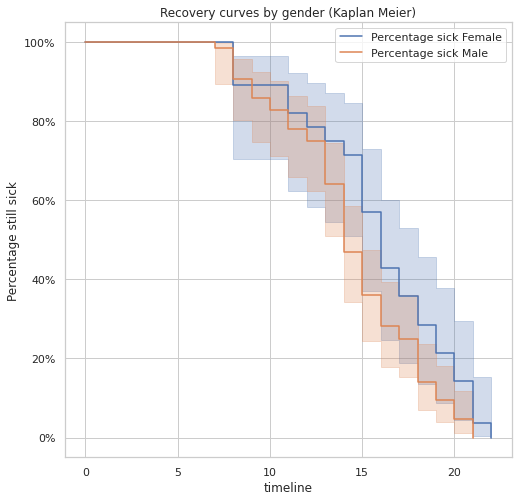

In [7]:


fig = plt.figure(figsize = figsize)
for gender, grouped_gender in covid_gender.groupby('Gender'):
    time_to_recovery = grouped_gender['time_to_recovery']
    event_occured = np.empty(len(time_to_recovery))
    event_occured.fill(1)
    kmf.fit(time_to_recovery, event_occured, label = 'Percentage sick ' + gender)
    ax = fig.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set(xlabel = 'Days since diagnosis' , ylabel = 'Percentage still sick', title = 'Recovery curves by gender (Kaplan Meier)')  
    kmf.plot()
    
  
#print(covid_recovered['Age Bracket'].value_counts())

<a id ='recovery_age'></a>
<a href ='#table_contents'> Return to Table of Contents </a>
## 6. Recovery rates by Age

For this part of the analysis we filter out the data, leaving only those who also have the age column filled out. We bucket the age groups into those under and over 50. Due to the sparsity of data, creating more buckets would lead to very few observations in each.

We have 94 patients, 63 under 50 years of and 31 over 50 years of age. The median time to recovery is much greater for those over 50(21 days) than those under 50 (14 days), this is more in line with what we know about the virus, and the increased fatality rate with age. 

A t-test run on the mean recovery times for the two age groups, resulted in a p-value really close to zero. 

--------  --
under 50  63
over 50   31
--------  --
Median time to recovery for the under 50 age group is 14 days.
Median time to recovery for the over 50 age group is 21 days.


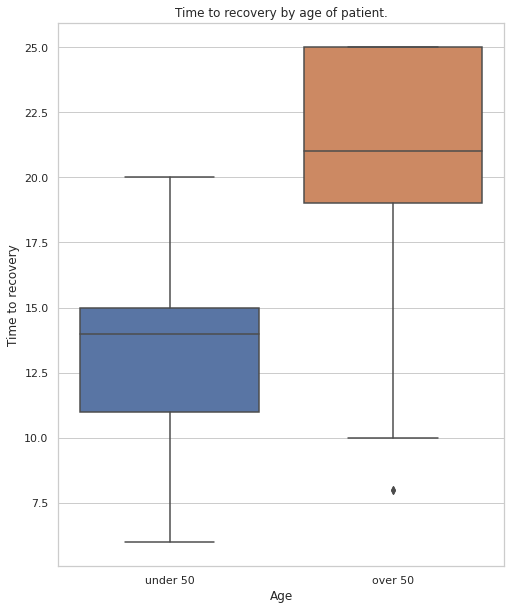

p-value  0.000


In [8]:

covid_recovered['Age Bracketf'] = covid_recovered['Age Bracket'].astype(float)
covid_recovered.loc[covid_recovered['Age Bracketf'] < 50 , 'Age Bucket' ] = 'under 50'
#covid_recovered.loc[(covid_recovered['Age Bracketf'] >=  40) & (covid_recovered['Age Bracketf'] < 65), 'Age Bucket' ] = 'between 40 and 65'
covid_recovered.loc[ covid_recovered['Age Bracketf'] >= 50, 'Age Bucket' ] = 'over 50'
covid_age = covid_recovered[pd.notnull(covid_recovered['Age Bracketf'])]

print(tabulate(pd.DataFrame(covid_age['Age Bucket'].value_counts())))

#print(tabulate(pd.DataFrame(covid_age.loc[covid_age['Age Bucket']=='over 50','time_to_recovery'].value_counts())))
#print(tabulate(pd.DataFrame(covid_age.loc[covid_age['Age Bucket']=='under 50','time_to_recovery'].value_counts())))

med_time_to_recovery_under50 =  covid_age.loc[covid_age['Age Bucket']=='under 50','time_to_recovery'].median()
print("Median time to recovery for the under 50 age group is{0: .0f} days.".format(med_time_to_recovery_under50))

med_time_to_recovery_over50 =  covid_age.loc[covid_age['Age Bucket']=='over 50','time_to_recovery'].median()
print("Median time to recovery for the over 50 age group is{0: .0f} days.".format(med_time_to_recovery_over50))
figsize = (8,10)

fig = plt.figure(figsize = figsize)
ax = sns.boxplot(x = 'Age Bucket' , y = 'time_to_recovery' , data = covid_age[covid_age['time_to_recovery']!=0])
ax.set(xlabel = 'Age' , ylabel = 'Time to recovery', title = 'Time to recovery by age of patient.')
plt.close(2)
plt.close(3)
#plt.table(loc = 'bottom', cellText = cell_text)
plt.show()
ttest,pval = ttest_ind(covid_age.loc[covid_age['Age Bucket']=='under 50','time_to_recovery'],covid_age.loc[covid_age['Age Bucket']=='over 50','time_to_recovery'])
print("p-value {0: .3f}".format(pval))

**How many people remain sick a given number of days after diagnosis ?**

We again draw Kaplan-Meier curves for each age group, superimposed on the same axes. The steeper slope for those under 50 indicate a quicker recovery for that age group. 

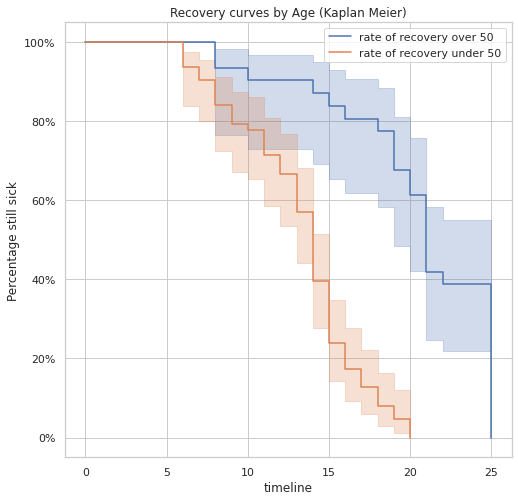

In [9]:

figsize = (8,8)
fig = plt.figure(figsize=figsize)
for age, grouped_age in covid_age.groupby('Age Bucket'):
    time_to_recovery = grouped_age['time_to_recovery']
    event_occured = np.empty(len(time_to_recovery))
    event_occured.fill(1)
    ax = fig.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set(xlabel = 'Days since diagnosis' , ylabel = 'Percentage still sick', title = 'Recovery curves by Age (Kaplan Meier)')  
    kmf.fit(time_to_recovery, event_occured, label = 'rate of recovery ' + age)
    kmf.plot()


<a id ='recovery_age_sex'></a>
<a href ='#table_contents'> Return to Table of Contents </a>
## 7. Recovery rates by age and sex

For this analysis by age and sex, we use a slightly different approach. We use the [*Cox Proportional Hazard Model*](http://www.sthda.com/english/wiki/cox-proportional-hazards-model), which estimates the hazard function, which is the instaneous probability of an event's occurence, given it hasn't occured so far. That is, for a given patient, if they haven't recovered until day k, what is the probability that they will recover on day k? 

The analysis chooses a baseline group, in this case women over 50, and then assumes proportional hazards for the other groups. That is, the hazard curves for the other groups (females under 50, males under 50 and males over 50) are proportional and can't cross. That is, if an individual has an instantaneous probability of recovery at the initial time point that is twice as high as that of another individual, then at all later times the instantaneous probability of recovery remains twice as high. 

Once the model is fit, we notice an extremely high p-value on the male coefficient, this means that there is very low confidence that there is a difference in the instantaneous probability of recovery between men and women. 

We also notice a very low p-value in the age coefficient, showing a high level of confidence that there is a difference in the instantaneous probability of recovery of those over 50 compared to those under 50. (By this analysis, on a given day a woman under 50 has a probability of recovery 4.43 times as high as a woman over 50)


In [10]:
from lifelines import CoxPHFitter


covid_recovered['recovered'] = 1
covid_age_gender = covid_recovered[(pd.notnull(covid_recovered['Age Bracketf'])&pd.notnull(covid_recovered['Gender']))]

print(pd.crosstab(covid_age_gender['Age Bucket'], covid_age_gender['Gender']))

cph = CoxPHFitter()
#enc = OneHotEncoder(drop = 'first', categories = [0,1])
Xtrain = covid_age_gender[['Age Bucket','Gender','time_to_recovery','recovered']]

## drop a dummy to avoid the dummy variable trap
Xtrain2 = pd.get_dummies(Xtrain, columns=['Age Bucket', 'Gender'], drop_first=True)

cox_fit = cph.fit(Xtrain2, duration_col='time_to_recovery', event_col='recovered')

cph.print_summary()

Gender       F   M
Age Bucket        
over 50     11   8
under 50    11  45


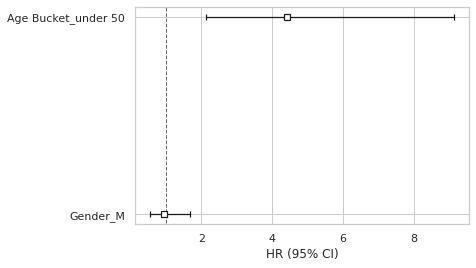

In [11]:
#cph.plot_covariate_groups(covariates = ['Gender_M', 'Age Bucket_under 50'], values = [[0,1],[0,1]])
cph.plot(hazard_ratios=True)
plt.show()
#close all plots
plt.close('all')

 <a id ='what_learned'></a>
<a href ='#table_contents'> Return to Table of Contents </a>
## 8. What did we learn ?

Many different assumptions were made in this analysis and we were plagued by sparse, unreliable data, but despite this we did get indications pointing us in the right direction (faster recovery times in younger people). I expect some good criticism of this analysis, but we did learn the following.

1) With a high degree of confidence younger people recover faster than older people.

2) The differences between sexes wasn't as apparent, in fact we couldn't say much with a good degree of confidence. 

3) Confounding effects (like disproportionate distribution of age over the sexes) could lead to surprising results like males recovering farter than females. 

4) Such analysis may lead to more fruitful results in a larger dataset with more variables. For eg: we could analyze the result of different medications and treatments on recovery times.

5) Recovery times may follow trends similar to fatality rates, with older people taking longer to recovery. 


<a id ='references'></a>
<a href ='#table_contents'> Return to Table of Contents </a>
## 9. References 

http://www.sthda.com/english/wiki/cox-proportional-hazards-model

https://lifelines.readthedocs.io/en/latest/


Constructive criticism of this analysis is more than welcome. I'm looking forward to some. Maybe we can work on improving it together! 
If you enjoyed this analysis, I'm looking for opportunities in Data Science and Machine learning, you can contact me @ gowri.thampi@gmail.com. 